#### 13. This question should be answered using the Weekly data set, which is part of the `ISLP` package. This data is similar in nature to the Smarket data from this chapter’s lab, except that it contains $1089$ weekly returns for $21$ years, from the beginning of $1990$ to the end of $2010$.
1. Produce some numerical and graphical summaries of the Weekly data. Do there appear to be any patterns?
2. Use the full data set to perform a logistic regression with Direction as the response and the five lag variables plus Volume as predictors. Use the summary function to print the results. Do any of the predictors appear to be statistically significant? If so, which ones?
3. Compute the confusion matrix and overall fraction of correct predictions. Explain what the confusion matrix is telling you about the types of mistakes made by logistic regression.
4. Now fit the logistic regression model using a training data period from 1990 to 2008, with Lag2 as the only predictor. Compute the confusion matrix and the overall fraction of correct predictions for the held out data (that is, the data from 2009 and 2010).
5. Repeat (4) using LDA.
6. Repeat (4) using QDA.
7. Repeat (4) using KNN with $K = 1$.
8. Which of these methods appears to provide the best results on this data?
9. Experiment with different combinations of predictors, including possible transformations and interactions, for each of the methods. Report the variables, method, and associated confusion matrix that appears to provide the best results on the held out data. Note that you should also experiment with values for K in the KNN classifier.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import ISLP
import ISLP.models

import statsmodels.api as sm

In [2]:
Weekly: pd.DataFrame = ISLP.load_data("Weekly")
Weekly.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


In [3]:
Weekly.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000
mean,2000.048669,0.150585,0.151079,0.147205,0.145818,0.139893,1.574618,0.149899
std,6.033182,2.357013,2.357254,2.360502,2.360279,2.361285,1.686636,2.356927
min,1990.000000,-18.195000,-18.195000,-18.195000,-18.195000,-18.195000,0.087465,-18.195000
25%,1995.000000,-1.154000,-1.154000,-1.158000,-1.158000,-1.166000,0.332022,-1.154000
50%,2000.000000,0.241000,0.241000,0.241000,0.238000,0.234000,1.002680,0.241000
75%,2005.000000,1.405000,1.409000,1.409000,1.409000,1.405000,2.053727,1.405000
max,2010.000000,12.026000,12.026000,12.026000,12.026000,12.026000,9.328214,12.026000


In [4]:
print(len(Weekly), len(Weekly[Weekly.Direction == "Up"]), len(Weekly[Weekly.Direction == "Down"]))

1089 605 484


In [5]:
Weekly.corr(numeric_only=True)

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,-0.032289,-0.033390,-0.030006,-0.031128,-0.030519,0.841942,-0.032460
Lag1,-0.032289,1.000000,-0.074853,0.058636,-0.071274,-0.008183,-0.064951,-0.075032
Lag2,-0.033390,-0.074853,1.000000,-0.075721,0.058382,-0.072499,-0.085513,0.059167
Lag3,-0.030006,0.058636,-0.075721,1.000000,-0.075396,0.060657,-0.069288,-0.071244
Lag4,-0.031128,-0.071274,0.058382,-0.075396,1.000000,-0.075675,-0.061075,-0.007826
Lag5,-0.030519,-0.008183,-0.072499,0.060657,-0.075675,1.000000,-0.058517,0.011013
Volume,0.841942,-0.064951,-0.085513,-0.069288,-0.061075,-0.058517,1.000000,-0.033078
Today,-0.032460,-0.075032,0.059167,-0.071244,-0.007826,0.011013,-0.033078,1.000000


Text(0, 0.5, 'Volume')

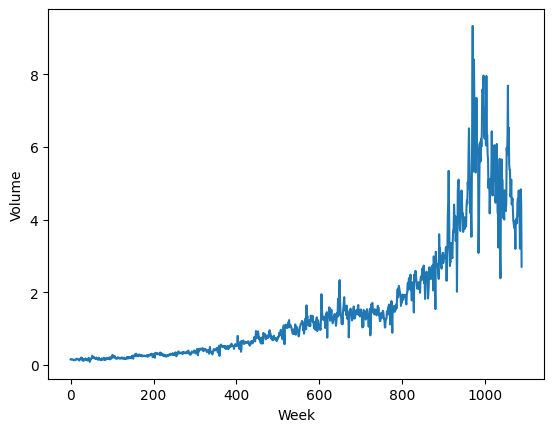

In [6]:
plt.plot(range(len(Weekly)), Weekly.Volume)
plt.xlabel("Week")
plt.ylabel("Volume")

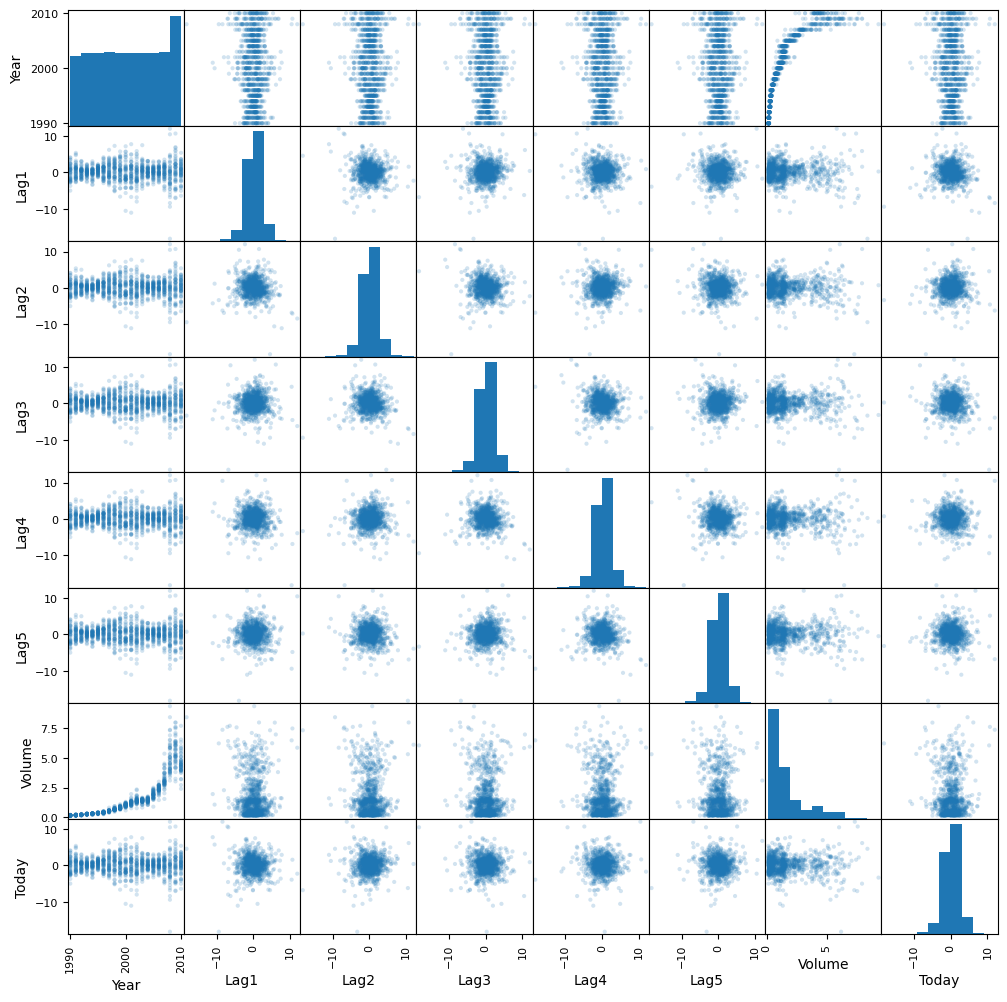

In [7]:
pd.plotting.scatter_matrix(Weekly, alpha=0.2, figsize=(12, 12), diagonal="hist");

## 2

In [8]:
allvars: list[str] = [f"Lag{i + 1}" for i in range(5)] + ["Volume"]
design = ISLP.models.ModelSpec(allvars)
X = design.fit_transform(Weekly)
y = Weekly.Direction == "Up"
glm = sm.GLM(y, X, family=sm.families.Binomial())
results = glm.fit()
_summary: pd.DataFrame = ISLP.models.summarize(results)

In [9]:
stat_sig_threshold = 0.05
stat_sig_params: list[str] = [
    name for name, _ in _summary[_summary["P>|z|"] < stat_sig_threshold].iterrows()
    if name != "intercept"
]
stat_sig_params

['Lag2']

## 3

In [10]:
labels = np.where(results.predict() > 0.5, "Up", "Down")
ct = ISLP.confusion_table(labels, Weekly.Direction)
ct

Truth,Down,Up
Predicted,,
Down,54,48
Up,430,557


We are significantly overpredicting up.

In [11]:
pct_correct_total = np.mean(labels == Weekly.Direction)
print(f"Our model predicts the correct movement {pct_correct_total*100:.2f}% of the time.")

for dir_ in ["Up", "Down"]:
    pct = ct.loc[dir_][dir_]/(ct.loc[dir_].sum())
    print(f"Our model is correct when it predicts an '{dir_}' movement {pct*100:.2f}% of the time.")

Our model predicts the correct movement 56.11% of the time.
Our model is correct when it predicts an 'Up' movement 56.43% of the time.
Our model is correct when it predicts an 'Down' movement 52.94% of the time.


## 4

In [12]:
train = Weekly[Weekly.Year <= 2008].copy()
test = Weekly[Weekly.Year > 2008].copy()

In [13]:
from statsmodels.genmod.generalized_linear_model import GLMResultsWrapper

allvars2: list[str] = ["Lag2"]
design = ISLP.models.ModelSpec(allvars2)
X2 = design.fit_transform(train)
y2 = train.Direction == "Up"
glm2 = sm.GLM(y2, X2, family=sm.families.Binomial())
results2: GLMResultsWrapper = glm2.fit()
_summary2: pd.DataFrame = ISLP.models.summarize(results)

In [14]:
probs = results2.predict(exog=design.fit_transform(test))
labels2 = np.where(probs > 0.5, "Up", "Down")
ct = ISLP.confusion_table(labels2, test.Direction)
ct

Truth,Down,Up
Predicted,,
Down,9,5
Up,34,56


In [15]:
print(f"Using only 'Lag2' we get correct predictions {np.mean(labels2 == test.Direction)*100:.2f}% of the time.")

Using only 'Lag2' we get correct predictions 62.50% of the time.


## 5

In [16]:
design = ISLP.models.ModelSpec(allvars2)
X3 = design.fit_transform(train)

In [17]:
X3

,intercept,Lag2
0,1.0,1.572
1,1.0,0.816
2,1.0,-0.270
3,1.0,-2.576
4,1.0,3.514
...,...,...
980,1.0,-8.389
981,1.0,12.026
982,1.0,-2.251
983,1.0,0.418


In [18]:
import sklearn.discriminant_analysis

lda = sklearn.discriminant_analysis.LinearDiscriminantAnalysis(store_covariance=True)
X = train[["Lag2"]].copy()
X["intercept"] = 1.0
X = X[["intercept", "Lag2"]]
lda.fit(X = X, y = train.Direction)

LinearDiscriminantAnalysis(store_covariance=True)

In [19]:
X_test = test[["Lag2"]].copy()
X_test["intercept"] = 1.0
X_test = X_test[["intercept", "Lag2"]]

In [20]:
print(f"We predict {np.mean(lda.predict(X_test) == test.Direction)*100:.2f}% correctly.")

We predict 62.50% correctly.


In [21]:
ct = ISLP.confusion_table(lda.predict(X_test), test.Direction)
ct

Truth,Down,Up
Predicted,,
Down,9,5
Up,34,56


In [22]:
ct.loc["Down"]["Down"]

9

In [23]:
len([1 for x in lda.predict_proba(X_test) if x[1] <= 0.5]) / len(lda.predict_proba(X_test))

0.1346153846153846

## 6

In [24]:
Weekly: pd.DataFrame = ISLP.load_data("Weekly")
train = Weekly[Weekly.Year <= 2008].copy()
test = Weekly[Weekly.Year > 2008].copy()

In [25]:
X_train = train[["Lag2"]].copy()
X_train["intercept"] = 1.0
X_train = X_train[["intercept", "Lag2"]]

In [26]:
import sklearn.discriminant_analysis

qda = sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis(store_covariance=True)
qda.fit(X_train[["Lag2"]], train.Direction)

QuadraticDiscriminantAnalysis(store_covariance=True)

In [27]:
qda.predict(X_test[["Lag2"]])

array(['Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up', 'Up',
       'Up', 'Up', 'Up', 'Up', 'Up'], dtype=object)

## 7

## 8

## 9

# Playground

In [28]:
Weekly = ISLP.load_data("Weekly")

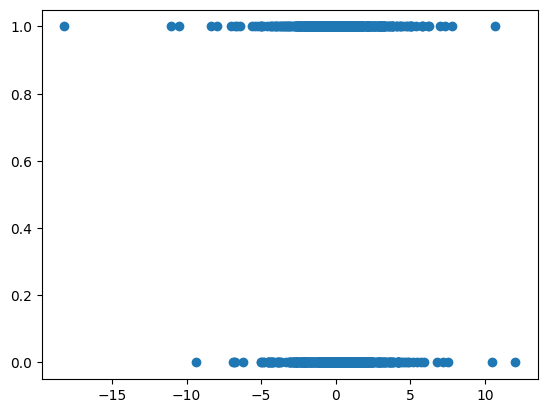

In [29]:
plt.scatter(Weekly.Lag1, np.where(Weekly.Direction == "Up", 1, 0))

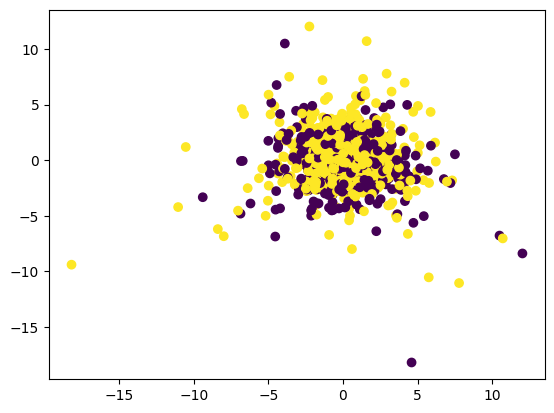

In [30]:
plt.scatter(Weekly.Lag1, Weekly.Lag2, c=np.where(Weekly.Direction == "Up", 1, 0))

In [31]:
Smarket = ISLP.load_data('Smarket')

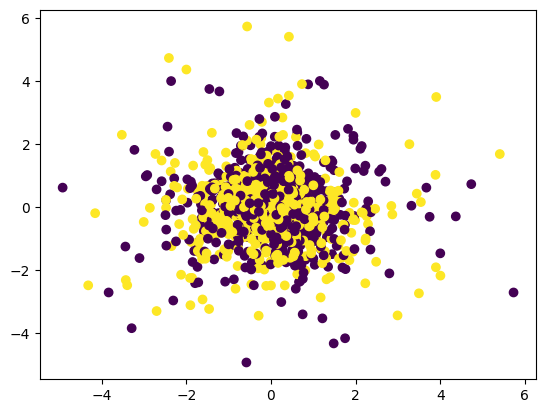

In [32]:
plt.scatter(Smarket.Lag1, Smarket.Lag2, c=np.where(Smarket.Direction == "Up", 1, 0))

In [33]:
train: pd.DataFrame = Smarket.iloc[np.where(Smarket.Year < 2005)]
test: pd.DataFrame = Smarket.iloc[np.where(Smarket.Year >= 2005)]

X_train: pd.DataFrame = train[["Lag1", "Lag2"]].copy()
y_train: pd.Series = train.Direction

X_test: pd.DataFrame= test[["Lag1", "Lag2"]].copy()
y_test: pd.Series = test.Direction

In [34]:
qda = sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis(store_covariance=True)
qda.fit(X_train, y_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

In [35]:
np.mean(qda.predict(X_test) == y_test)

0.5992063492063492

In [36]:
import sklearn.datasets

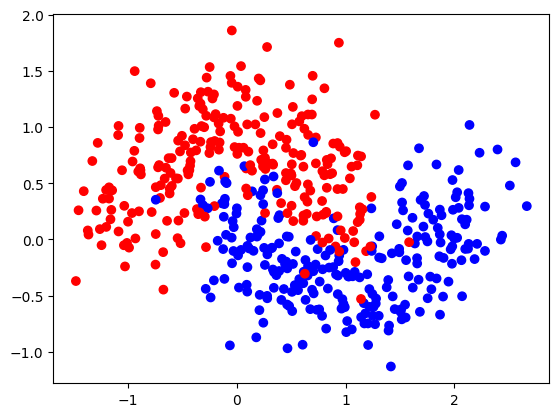

In [37]:
n = 500
pct_test = 0.2
n_train = int(n*(1-pct_test))

X, y = sklearn.datasets.make_moons(500, shuffle=True, noise=0.3, random_state=0x2024_04_24)
X_train: np.ndarray = X[:n_train]
y_train: np.ndarray = y[:n_train]

X_test: np.ndarray = X[n_train:]
y_test: np.ndarray = y[n_train:]

colors = np.where(y == 0, "red", "blue")
plt.scatter(X[:, 0], X[:, 1], c=colors)

In [38]:
qda = sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis(store_covariance=True)
qda.fit(X_train, y_train)

QuadraticDiscriminantAnalysis(store_covariance=True)

In [39]:
np.mean(qda.predict(X_test) == y_test)

0.84

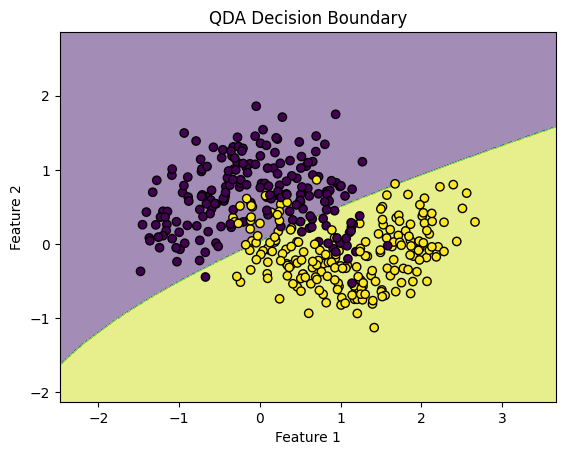

In [40]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Step 2: Generate a grid of points
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))

# Step 3: Predict over the grid
Z = gnb.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Step 4: Plot the decision boundary
plt.contourf(xx, yy, Z, alpha=0.5)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors='k')
plt.title("QDA Decision Boundary")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [41]:
gnb.predict(X_test)

array([0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1])

In [42]:
import torch
import torch.nn as nn

In [43]:
X_train.shape, y_train.shape

((400, 2), (400,))

/Users/danielsinkin/GitHub_private/statlearning/.venv/lib/python3.11/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


Epoch 1, Loss: 0.5368133783340454
Epoch 2, Loss: 0.6072503328323364
Epoch 3, Loss: 0.5230890512466431
Epoch 4, Loss: 0.5124807357788086
Epoch 5, Loss: 0.5094687938690186
Epoch 6, Loss: 0.5500969886779785
Epoch 7, Loss: 0.5647873282432556
Epoch 8, Loss: 0.402812659740448
Epoch 9, Loss: 0.5368172526359558
Epoch 10, Loss: 0.3976207375526428
Epoch 11, Loss: 0.434810072183609
Epoch 12, Loss: 0.5929118990898132
Epoch 13, Loss: 0.3642258644104004
Epoch 14, Loss: 0.4803321361541748
Epoch 15, Loss: 0.5616689920425415
Epoch 16, Loss: 0.3146594166755676
Epoch 17, Loss: 0.3304559886455536
Epoch 18, Loss: 0.4120601713657379
Epoch 19, Loss: 0.537848174571991
Epoch 20, Loss: 0.46051234006881714
Epoch 21, Loss: 0.41827693581581116
Epoch 22, Loss: 0.3279051184654236
Epoch 23, Loss: 0.40104159712791443
Epoch 24, Loss: 0.5180991888046265
Epoch 25, Loss: 0.6210753321647644
Epoch 26, Loss: 0.4207562804222107
Epoch 27, Loss: 0.6101993918418884
Epoch 28, Loss: 0.5711514353752136
Epoch 29, Loss: 0.34171119332

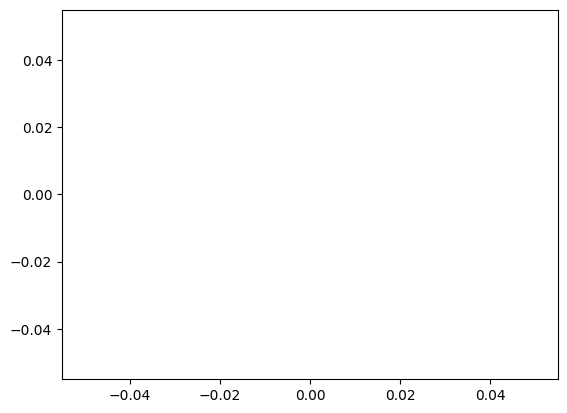

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

n = 1_000 
pct_test = 0.2
n_train = int(n*(1-pct_test))

X, y = sklearn.datasets.make_moons(n, shuffle=True, noise=0.35, random_state=0x2024_04_24)
X_train: np.ndarray = X[:n_train]
y_train: np.ndarray = y[:n_train]

X_test: np.ndarray = X[n_train:]
y_test: np.ndarray = y[n_train:]

colors = np.where(y == 0, "red", "blue")

# Assuming X_train and y_train are available as NumPy arrays
X_train_tensor: torch.Tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor: torch.Tensor = torch.tensor(y_train, dtype=torch.long)

# Create a dataset and data loader
dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset, batch_size=10, shuffle=True)  # You can adjust batch size

model = nn.Sequential(
    nn.LazyLinear(50),
    nn.ReLU(),
    nn.Linear(50, 2),
    nn.Softmax(dim = 1), 
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adjust the learning rate as needed

num_epochs = 100  # Define the number of epochs

losses = []
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()  # Reset gradients to zero for each batch
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # Backpropagate the error
        optimizer.step()  # Adjust weights

    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

plt.plot(range(len(losses)), losses)

In [45]:
model = nn.Sequential(
    nn.LazyLinear(50),
    nn.ReLU(),
    nn.Linear(50, 2),
)

Running experiment 1 (0.00% done)
(n, num_epochs, num_nodes)=(1000, 100, 1)
Test Accuracy: 40.50%
Running experiment 2 (3.70% done)
(n, num_epochs, num_nodes)=(1000, 100, 2)
Test Accuracy: 45.00%
Running experiment 3 (7.41% done)
(n, num_epochs, num_nodes)=(1000, 100, 5)
Test Accuracy: 88.00%
Running experiment 4 (11.11% done)
(n, num_epochs, num_nodes)=(1000, 100, 25)
Test Accuracy: 100.00%
Running experiment 5 (14.81% done)
(n, num_epochs, num_nodes)=(1000, 100, 50)
Test Accuracy: 100.00%
Running experiment 6 (18.52% done)
(n, num_epochs, num_nodes)=(1000, 100, 100)
Test Accuracy: 100.00%


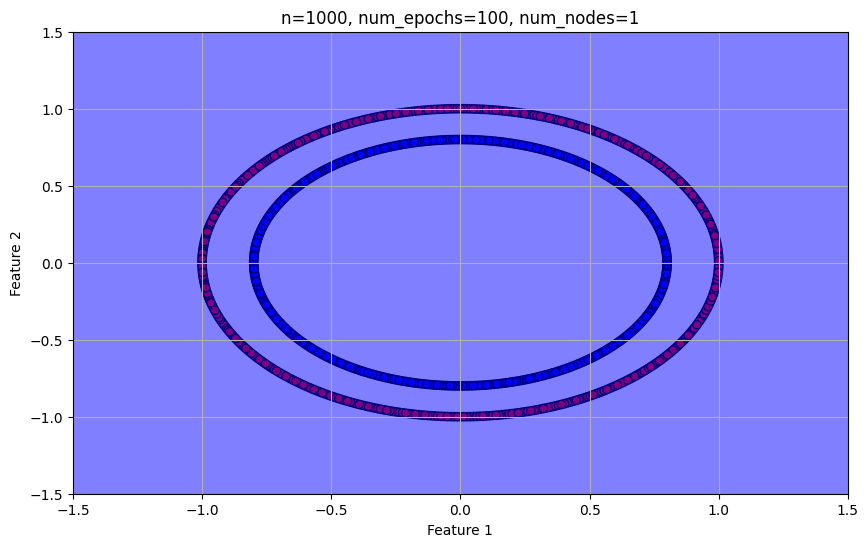

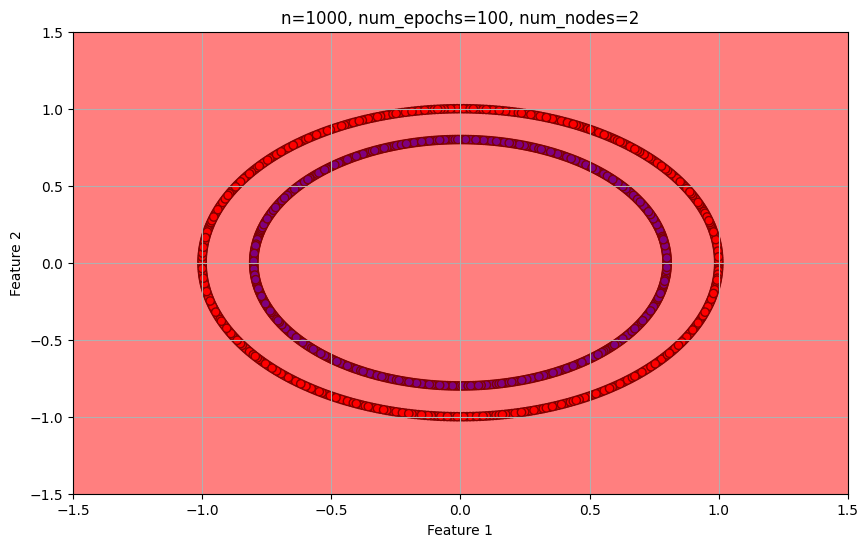

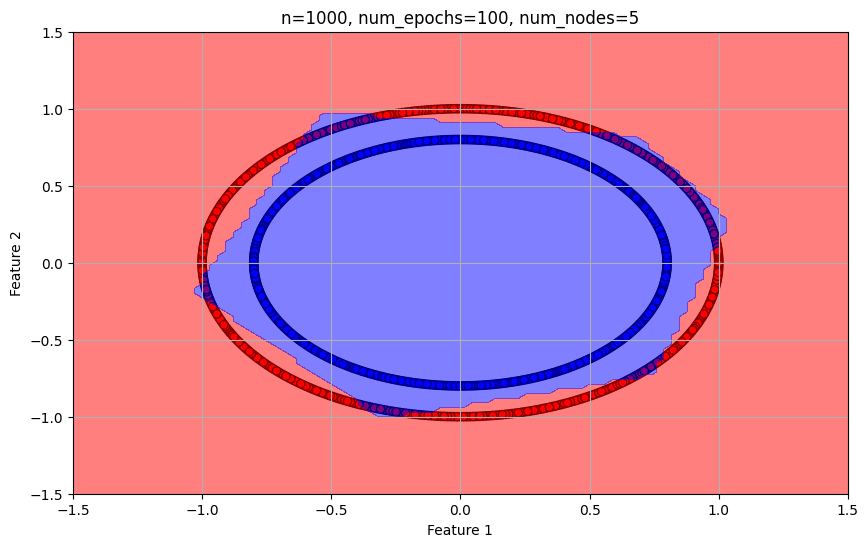

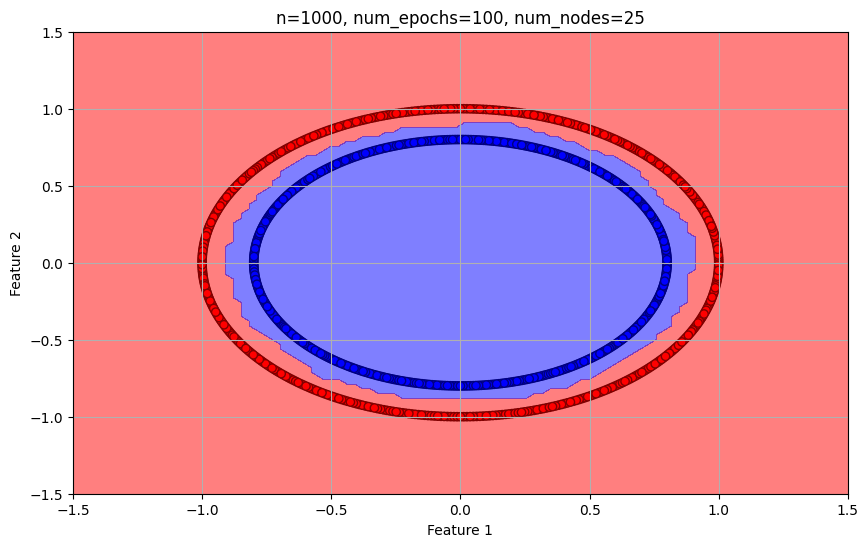

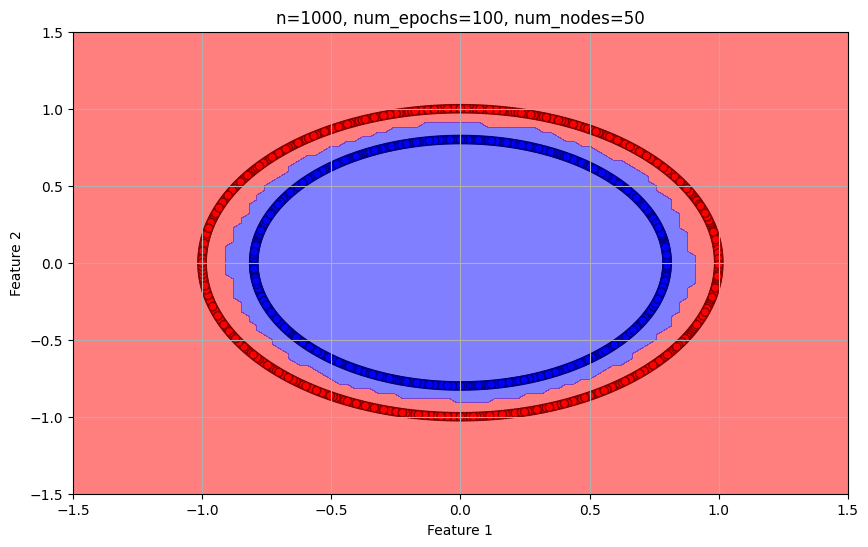

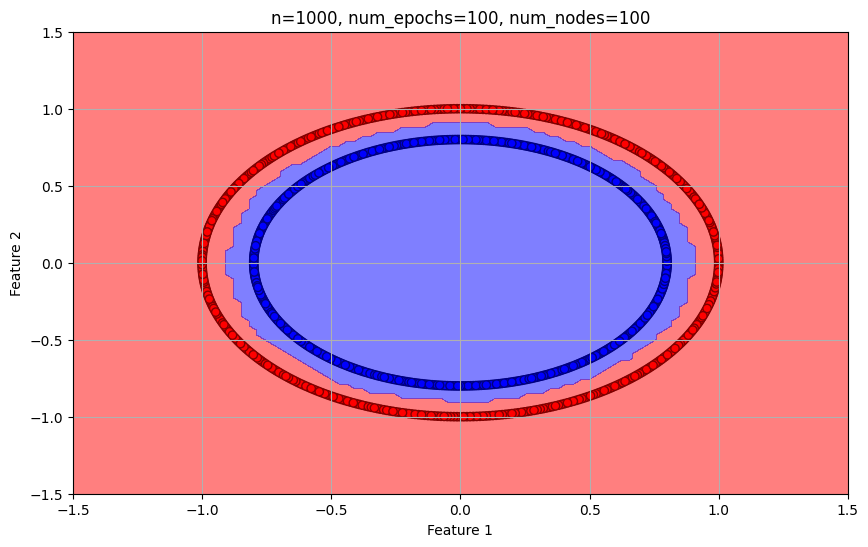

In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import sklearn.datasets

import itertools

for i, (n, num_epochs, num_nodes) in enumerate(itertools.product([1000], [100], [1, 2, 5, 25, 50, 100])):
    print(f"Running experiment {i+1} ({i / 27*100:.2f}% done)")
    print(f"{(n, num_epochs, num_nodes)=}")
    pct_test = 0.2
    n_train = int(n * (1 - pct_test))
    # X, y = sklearn.datasets.make_moons(n, shuffle=True, noise=0.35, random_state=0x20240424)
    X, y = sklearn.datasets.make_circles(n)
    X_train: np.ndarray = X[:n_train]
    y_train: np.ndarray = y[:n_train]
    X_test: np.ndarray = X[n_train:]
    y_test: np.ndarray = y[n_train:]

    # Converting to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # DataLoader setup
    dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(dataset, batch_size=10, shuffle=True)

    # Model definition
    model = nn.Sequential(
        nn.LazyLinear(num_nodes),
        nn.ReLU(),
        nn.LazyLinear(2)
    )

    # Loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)

    # Training function
    def train(model, train_loader, loss_fn, optimizer, num_epochs=num_epochs):
        model.train()
        for epoch in range(num_epochs):
            for batch, (X_batch, y_batch) in enumerate(train_loader):
                pred = model(X_batch)
                loss = loss_fn(pred, y_batch)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

    # Evaluation function
    def evaluate(model, X_test_tensor, y_test_tensor):
        model.eval()
        with torch.no_grad():
            predictions = model(X_test_tensor)
            predicted_classes = predictions.argmax(1)
            accuracy = (predicted_classes == y_test_tensor).type(torch.float32).mean().item()
        return accuracy

    # Running the training and evaluation
    train(model, train_loader, loss_fn, optimizer, num_epochs=50)
    accuracy = evaluate(model, X_test_tensor, y_test_tensor)
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    import numpy as np
    import matplotlib.pyplot as plt
    import torch

    # Dataset
    colors = np.where(y == 0, 'red', 'blue')

    # Create a mesh grid for the decision boundary
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.tensor(grid, dtype=torch.float32)

    # Predict over the grid
    model.eval()
    with torch.no_grad():
        preds = model(grid_tensor)
        preds = preds.argmax(1).numpy()

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(X[:, 0], X[:, 1], c=colors, edgecolors='k')
    contour = plt.contourf(xx, yy, preds.reshape(xx.shape), alpha=0.5, levels=np.arange(3)-0.5, colors=['red', 'blue'])
    plt.title(f"{n=}, {num_epochs=}, {num_nodes=}")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid(True)
    plt.savefig(f"moon_{n}_{num_epochs}_{num_nodes}.png")

In [ ]:
X, y = make_moons(n, shuffle=True, noise=0.35, random_state=0x20240424)

In [ ]:
X, y = sklearn.datasets.make_circles(100)

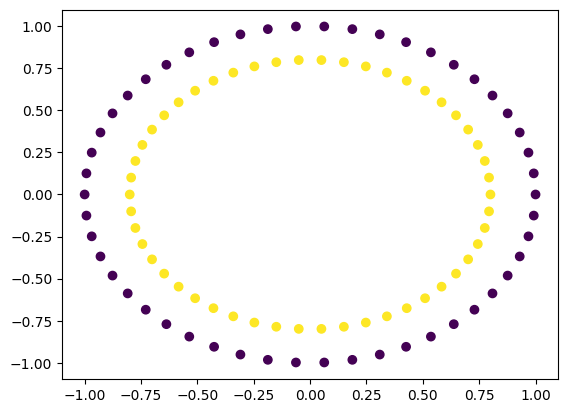

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y)